### Project Setup

In [1]:
import mlx.core as mx
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm, trange
from pathlib import Path
from matplotlib.colors import ListedColormap, BoundaryNorm
import ipywidgets as widgets
from KSS import KSS

### File Location

In [2]:
ROOT = Path.cwd()
MAT_DIR = ROOT / "MAT Files"
GT_DIR = ROOT / "GT Files"

### Datasets - Files & Keys

In [3]:
DATASETS = {
    "Pavia": {
        "data_file": "Pavia.mat",
        "gt_file":   "Pavia_gt.mat",
        "data_key":  "pavia",
        "gt_key":    "pavia_gt",
    },
    "PaviaUni": {
        "data_file": "PaviaUni.mat",
        "gt_file":   "PaviaU_gt.mat",
        "data_key":  "paviaU",
        "gt_key":    "paviaU_gt",
    },
    "Salinas": {
        "data_file":  "Salinas_corrected.mat",
        "gt_file":    "Salinas_gt.mat",
        "data_key":   "salinas_corrected",
        "gt_key":     "salinas_gt",
    },
    "Indian pines":{
        "data_file":  "Indian_pines.mat",
        "gt_file":    "Indian_pines_gt.mat",
        "data_key":   "indian_pines",
        "gt_key":     "indian_pines_gt",
    }
}

In [4]:
DEFAULT_DS = "Pavia"

ds = widgets.Dropdown(options=list(DATASETS.keys()),
                      value=DEFAULT_DS,
                      description="Dataset:")
out = widgets.Output()

display(ds, out)

Dropdown(description='Dataset:', options=('Pavia', 'PaviaUni', 'Salinas', 'Indian pines'), value='Pavia')

Output()

In [5]:
keys = DATASETS[ds.value]

In [6]:
keys

{'data_file': 'Pavia.mat',
 'gt_file': 'Pavia_gt.mat',
 'data_key': 'pavia',
 'gt_key': 'pavia_gt'}



## Hyperspectral Image Cube

In [7]:
def load_ds(name: str):
    """Load data for the selected dataset and put into globals()."""
    cfg = DATASETS[name]
    data_mat = sio.loadmat(os.path.join(MAT_DIR, cfg["data_file"]))
    gt_mat   = sio.loadmat(os.path.join(GT_DIR,  cfg["gt_file"]))
    globals()["data_cube"] = data_mat[cfg["data_key"]]
    globals()["gt_data"]   = gt_mat[cfg["gt_key"]]
    with out:
        out.clear_output(wait=True)
        print(f"Loaded {name}: X {data_cube.shape}, GT {gt_data.shape}")


In [8]:
def _on_change(change):
    if change["name"] == "value":
        load_ds(change["new"])

In [9]:
ds.observe(_on_change, names="value")

In [10]:
load_ds(ds.value)

## Ground Truth Data

In [11]:
gt_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1096, 715), dtype=uint8)

In [12]:
gt_data.shape

(1096, 715)

In [13]:
gt_labels = np.sort(np.unique(gt_data))

In [14]:
num_labels = len(gt_labels)

In [16]:
bg_indices = gt_data == 0

In [17]:
filter = mx.ones([data_cube.shape[0], data_cube.shape[1]])

In [18]:
mask = mx.where(bg_indices, 0.0, filter)

In [20]:
mask3d = mask[..., None]

In [21]:
masked_cube = mx.multiply(data_cube, mask3d)

In [25]:
masked_cube_reshaped = mx.reshape(masked_cube, (masked_cube.shape[0]*masked_cube.shape[1], masked_cube.shape[2]))

In [28]:
cube_np = np.array(masked_cube_reshaped)
nonzero_mask = np.any(cube_np != 0, axis=1)
filtered_np = cube_np[nonzero_mask]
filtered_pixels = mx.array(filtered_np)

### Fit the Model

In [29]:
model = KSS(
    n_clusters=num_labels-1,
    subspaces_dims=2,
    max_iter=100,
    n_init=150,
    verbose=1,
    random_state=10)

In [30]:
%%time
model.fit(filtered_pixels.T)

Running KSS with n_clusters=9, subspaces_dims=[2, 2, 2, 2, 2, 2, 2, 2, 2], max_iter=100, n_init=150
 KSS run 1/150
  Run cost: 2.4692e+13
 KSS run 2/150
  Run cost: 2.4692e+13
 KSS run 3/150
  Run cost: 2.4693e+13
 KSS run 4/150
  Run cost: 2.4691e+13
 KSS run 5/150
  Run cost: 2.4688e+13
 KSS run 6/150
  Run cost: 2.4692e+13
 KSS run 7/150
  Run cost: 2.4692e+13
 KSS run 8/150
  Run cost: 2.4692e+13
 KSS run 9/150
  Run cost: 2.4689e+13
 KSS run 10/150
  Run cost: 2.4691e+13
 KSS run 11/150
  Run cost: 2.4690e+13
 KSS run 12/150
  Run cost: 2.4690e+13
 KSS run 13/150
  Run cost: 2.4689e+13
 KSS run 14/150
  Run cost: 2.4690e+13
 KSS run 15/150
  Run cost: 2.4691e+13
 KSS run 16/150
  Run cost: 2.4691e+13
 KSS run 17/150
  Run cost: 2.4693e+13
 KSS run 18/150
  Run cost: 2.4692e+13
 KSS run 19/150
  Run cost: 2.4691e+13
 KSS run 20/150
  Run cost: 2.4685e+13
 KSS run 21/150
  Run cost: 2.4688e+13
 KSS run 22/150
  Run cost: 2.4690e+13
 KSS run 23/150
  Run cost: 2.4691e+13
 KSS run 24/

In [31]:
labels = model.labels_

In [41]:
# labels

In [42]:
for k in range(1, num_labels):
    ilist = np.nonzero(labels == k)[0]
    print(f"Cluster {k}: {ilist}")

Cluster 1: [     4      5     16 ... 104460 104580 105652]
Cluster 2: [     0      9     10 ... 148007 148015 148135]
Cluster 3: [   137    138    139 ... 148149 148150 148151]
Cluster 4: [    63    133    201 ... 148119 148141 148143]
Cluster 5: [   210    211    212 ... 145464 147928 148142]
Cluster 6: [   323    398    630 ... 148130 148132 148148]
Cluster 7: [     1      2      3 ... 145465 145511 146777]
Cluster 8: [    67     68    931 ... 144673 144682 144891]
Cluster 9: [   135    136    204 ... 148140 148144 148145]


### Creating a clustermap

In [34]:
label_px = gt_data > 0 # Returns a boolean map with background pixels stored as False

clustermap = np.zeros_like(gt_data, dtype=np.int32) # Create a zero filled 2D array size of gt_data

clustermap[label_px] = labels # Fills the foreground pixels

### Plot - Ground Truth Vs Cluster assignment

In [35]:
def plot_gt_vs_clusters(gt_data, clustermap, title_left="Ground Truth", title_right="KSS Clustering Results"):
    gt_max = int(np.max(gt_data))
    km_max = int(np.max(clustermap))
    n_classes = max(gt_max, km_max)

    # color 0 = background (black); then categorical colors for 1..n_classes
    base = plt.cm.tab20.colors  # plenty of distinct colors
    palette = ['black'] + [base[i % len(base)] for i in range(n_classes)]
    cmap = ListedColormap(palette)
    norm = BoundaryNorm(np.arange(n_classes + 2) - 0.5, cmap.N)  # hard bins at integers

    fig, axes = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True)

    im0 = axes[0].imshow(gt_data, cmap=cmap, norm=norm, interpolation='nearest')
    axes[0].set_title(title_left, fontsize=16)
    axes[0].axis('equal'); axes[0].set_xticks([]); axes[0].set_yticks([])

    im1 = axes[1].imshow(clustermap, cmap=cmap, norm=norm, interpolation='nearest')
    axes[1].set_title(title_right, fontsize=16)
    axes[1].axis('equal'); axes[1].set_xticks([]); axes[1].set_yticks([])

    # one colorbar per panel with integer ticks (0..n_classes)
    ticks = np.arange(0, n_classes + 1, 1)
    cbar0 = fig.colorbar(im0, ax=axes[0], ticks=ticks, orientation='horizontal', fraction=0.046, pad=0.05)
    cbar1 = fig.colorbar(im1, ax=axes[1], ticks=ticks, orientation='horizontal', fraction=0.046, pad=0.05)

    plt.show()

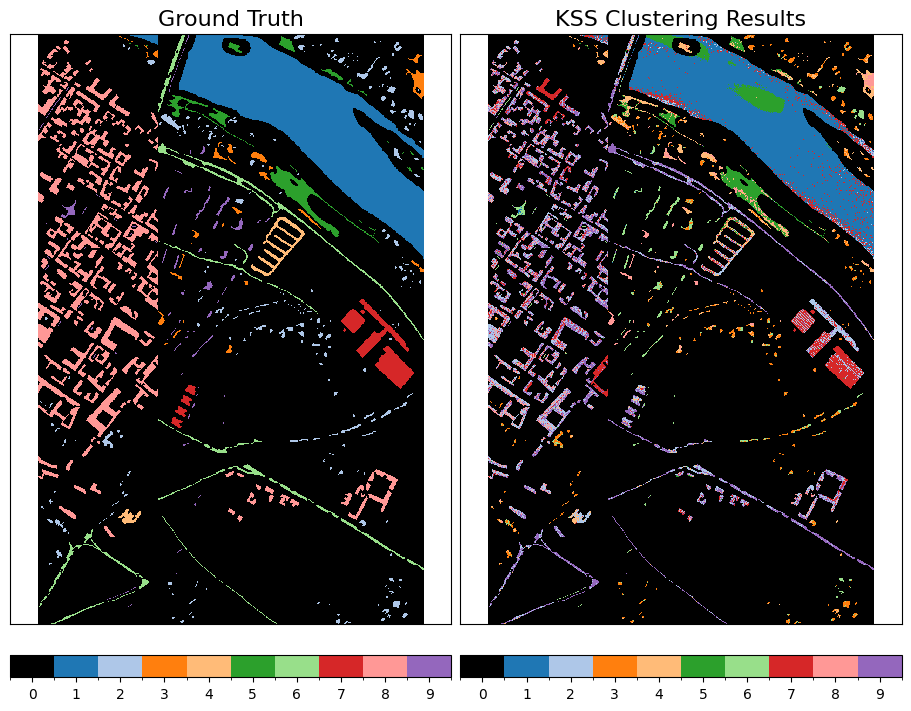

In [36]:
plot_gt_vs_clusters(gt_data, clustermap)